In [ ]:
import tensorflow
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping
import re
from nltk.corpus import stopwords
from nltk import word_tokenize
import nltk
nltk.download('stopwords')
STOPWORDS = set(stopwords.words('english'))
from bs4 import BeautifulSoup
import plotly.graph_objs as go
# import plotly.plotly as py
# import cufflinks
from IPython.core.interactiveshell import InteractiveShell
import plotly.figure_factory as ff
InteractiveShell.ast_node_interactivity = 'all'
from plotly.offline import iplot
# cufflinks.go_offline()
# cufflinks.set_config_file(world_readable=True, theme='pearl')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\mrnor\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional, SpatialDropout1D
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [ ]:
df = pd.read_csv("base_df.csv")
df['message'] = df['message'].astype(str)
df = df[df['category'] != -1]
df

,Unnamed: 0,message,category,field
0,0,Hi there! I am ready whenever you are :),124,generic
1,1,"yes, I agree. Information transmission is a pr...",124,transmission
2,2,"okay, thanks again. bye",124,generic
3,3,"Again to Jill: Yes, I agree with the behaviori...",123,transmission
4,4,All right. Thanks for the interesting discussi...,123,interactivity
...,...,...,...,...
4937,4937,"Uhm, I am running out of ideas...",101,generic
4938,4938,Do you both agree with the following statement...,101,technology
4939,4939,yes. technology refers to tools and machines t...,101,technology
4940,4940,Do you both agree with the following statement...,101,legit


In [ ]:
df = df.reset_index(drop=True)
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))

def clean_text(text):
    """
        text: a string

        return: modified initial string
    """
    text = text.lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text. substitute the matched string in REPLACE_BY_SPACE_RE with space.
    text = BAD_SYMBOLS_RE.sub('', text) # remove symbols which are in BAD_SYMBOLS_RE from text. substitute the matched string in BAD_SYMBOLS_RE with nothing.
    text = text.replace('x', '')
#    text = re.sub(r'\W+', '', text)
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # remove stopwors from text
    return text
df['message'] = df['message'].apply(clean_text)
df

,Unnamed: 0,message,category,field
0,0,hi ready whenever,124,generic
1,1,yes agree information transmission process com...,124,transmission
2,2,okay thanks bye,124,generic
3,3,jill yes agree behavioristic view reinforcemen...,123,transmission
4,4,right thanks interesting discussion getting in...,123,interactivity
...,...,...,...,...
4937,4937,uhm running ideas,101,generic
4938,4938,agree following statement technology refers tools,101,technology
4939,4939,yes technology refers tools machines may used ...,101,technology
4940,4940,agree following statement google effect refers...,101,legit


In [ ]:
# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 50000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 100
# This is fixed.
EMBEDDING_DIM = 100

tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(df['message'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 3061 unique tokens.


In [ ]:
X = tokenizer.texts_to_sequences(df['message'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)

Shape of data tensor: (4942, 100)


In [ ]:
Y = pd.get_dummies(df['field']).values
print('Shape of label tensor:', Y.shape)

Shape of label tensor: (4942, 10)


In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.10, random_state = 42)

print(X_train.shape, Y_train.shape)
print(X_test.shape, Y_test.shape)

(4447, 100) (4447, 10)
(495, 100) (495, 10)


In [ ]:
model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
model.add(SpatialDropout1D(0.3))
model.add(LSTM(64, dropout=0.3, recurrent_dropout=0.2)) # .2, .3, .4, .5
model.add(Dense(10, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 100, 100)          5000000   
                                                                 
 spatial_dropout1d_1 (Spatia  (None, 100, 100)         0         
 lDropout1D)                                                     
                                                                 
 lstm_1 (LSTM)               (None, 64)                42240     
                                                                 
 dense_1 (Dense)             (None, 10)                650       
                                                                 
Total params: 5,042,890
Trainable params: 5,042,890
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
epochs = 3
batch_size = 32

history = model.fit(X_train, Y_train,
                    epochs = epochs,
                    batch_size = batch_size,
                    validation_split = 0.2,
                    callbacks = [EarlyStopping(monitor = 'val_loss', patience = 3, min_delta = 0.0001)])

Epoch 1/3
112/112 [==============================] - 34s 278ms/step - loss: 1.1063 - accuracy: 0.6736 - val_loss: 0.8642 - val_accuracy: 0.7236
Epoch 2/3
112/112 [==============================] - 30s 270ms/step - loss: 0.7115 - accuracy: 0.7591 - val_loss: 0.7334 - val_accuracy: 0.7854
Epoch 3/3
112/112 [==============================] - 30s 272ms/step - loss: 0.5527 - accuracy: 0.8201 - val_loss: 0.6319 - val_accuracy: 0.8281


In [ ]:
accr = model.evaluate(X_test,Y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

16/16 [==============================] - 1s 51ms/step - loss: 0.6473 - accuracy: 0.8101
Test set
  Loss: 0.647
  Accuracy: 0.810


In [ ]:
def test_model():
    correct = 0
    wrong = 0
    result = {}
    for index, row in pd.read_csv("new_data.csv").iterrows():
        new_complaint = [row['message']]
        seq = tokenizer.texts_to_sequences(new_complaint)
        padded = pad_sequences(seq, maxlen=MAX_SEQUENCE_LENGTH)
        pred = model.predict(padded)
        labels = df.field.unique().tolist()
        predict_label = labels[np.argmax(pred)]
        result[index] = {
            "actual_label" : row['category'],
            "predicted_label" : predict_label
        }

        if predict_label == row['category']:
            correct += 1
        else:
            wrong += 1
    print(f"Right: {correct}\tWrong: {wrong}")

    return result

test_model()

1/1 [==============================] - 0s 55ms/step
Right: 142	Wrong: 863


{0: {'actual_label': 'augmented', 'predicted_label': 'representation'},
 1: {'actual_label': 'augmented', 'predicted_label': 'representation'},
 2: {'actual_label': 'augmented', 'predicted_label': 'interactivity'},
 3: {'actual_label': 'augmented', 'predicted_label': 'representation'},
 4: {'actual_label': 'augmented', 'predicted_label': 'interactivity'},
 5: {'actual_label': 'augmented', 'predicted_label': 'transmission'},
 6: {'actual_label': 'augmented', 'predicted_label': 'transmission'},
 7: {'actual_label': 'augmented', 'predicted_label': 'transmission'},
 8: {'actual_label': 'augmented', 'predicted_label': 'transmission'},
 9: {'actual_label': 'augmented', 'predicted_label': 'transmission'},
 10: {'actual_label': 'augmented', 'predicted_label': 'transmission'},
 11: {'actual_label': 'augmented', 'predicted_label': 'interactivity'},
 12: {'actual_label': 'augmented', 'predicted_label': 'interactivity'},
 13: {'actual_label': 'augmented', 'predicted_label': 'representation'},
 14:

In [ ]:
# Define the model
model = Sequential()
model.add(Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=100, input_length=MAX_SEQUENCE_LENGTH))
model.add(Bidirectional(LSTM(64, dropout=0.2, recurrent_dropout=0.2, return_sequences=True)))
model.add(Bidirectional(LSTM(32, dropout=0.2, recurrent_dropout=0.2)))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(10, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 100, 100)          306200    
                                                                 
 bidirectional (Bidirectiona  (None, 100, 128)         84480     
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 64)               41216     
 nal)                                                            
                                                                 
 dense_2 (Dense)             (None, 64)                4160      
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_3 (Dense)             (None, 10)               

In [ ]:
epochs = 3
batch_size = 32

history = model.fit(X_train, Y_train,
                    epochs = epochs,
                    batch_size = batch_size,
                    validation_split = 0.2,
                    callbacks = [EarlyStopping(monitor = 'val_loss', patience = 3, min_delta = 0.0001)])

Epoch 1/3
112/112 [==============================] - 118s 951ms/step - loss: 1.0783 - accuracy: 0.6775 - val_loss: 0.8241 - val_accuracy: 0.7101
Epoch 2/3
112/112 [==============================] - 96s 862ms/step - loss: 0.7305 - accuracy: 0.7414 - val_loss: 0.7739 - val_accuracy: 0.7730
Epoch 3/3
112/112 [==============================] - 95s 846ms/step - loss: 0.5850 - accuracy: 0.8018 - val_loss: 0.6459 - val_accuracy: 0.8079


In [ ]:
accr = model.evaluate(X_test,Y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

16/16 [==============================] - 2s 139ms/step - loss: 0.6771 - accuracy: 0.7859
Test set
  Loss: 0.677
  Accuracy: 0.786


In [ ]:
test_model()

1/1 [==============================] - 0s 109ms/step
Right: 98	Wrong: 907


{0: {'actual_label': 'augmented', 'predicted_label': 'legit'},
 1: {'actual_label': 'augmented', 'predicted_label': 'representation'},
 2: {'actual_label': 'augmented', 'predicted_label': 'interactivity'},
 3: {'actual_label': 'augmented', 'predicted_label': 'representation'},
 4: {'actual_label': 'augmented', 'predicted_label': 'legit'},
 5: {'actual_label': 'augmented', 'predicted_label': 'transmission'},
 6: {'actual_label': 'augmented', 'predicted_label': 'interactivity'},
 7: {'actual_label': 'augmented', 'predicted_label': 'interactivity'},
 8: {'actual_label': 'augmented', 'predicted_label': 'transmission'},
 9: {'actual_label': 'augmented', 'predicted_label': 'transmission'},
 10: {'actual_label': 'augmented', 'predicted_label': 'interactivity'},
 11: {'actual_label': 'augmented', 'predicted_label': 'legit'},
 12: {'actual_label': 'augmented', 'predicted_label': 'legit'},
 13: {'actual_label': 'augmented', 'predicted_label': 'transmission'},
 14: {'actual_label': 'augmented', '

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(df['message'], df['field'], test_size = 0.10, random_state = 42)


In [ ]:
Y_train.value_counts()

generic           2864
learning           510
transmission       451
interactivity      329
media              137
technology          89
representation      28
augmented           20
legit               11
virtual              5
Name: field, dtype: int64

In [ ]:
Y_test.value_counts()

generic           305
transmission       60
learning           55
interactivity      38
media              24
technology          9
representation      2
augmented           1
Name: field, dtype: int64

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns
from tueplots import bundles

plt.rcParams.update(bundles.icml2022())
import tueplots.constants.color.palettes as tue_palettes


import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)

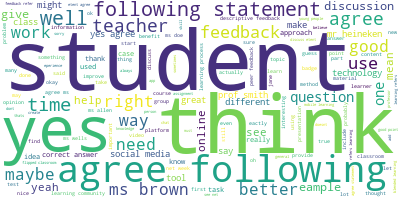

In [ ]:
long_string = ','.join(list(df['message'].values))

# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')
# Generate a word cloud
wordcloud.generate(long_string)
# Visualize the word cloud
wordcloud.to_image()

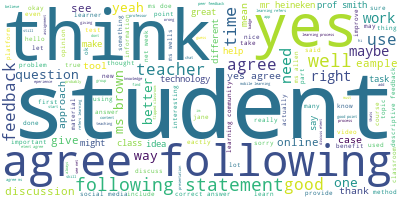

In [ ]:
long_string = ','.join(list(X_train.values))

# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')
# Generate a word cloud
wordcloud.generate(long_string)
# Visualize the word cloud
wordcloud.to_image()

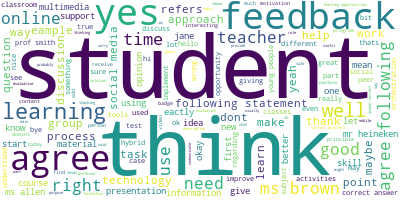

In [ ]:
long_string = ','.join(list(X_test.values))

# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')
# Generate a word cloud
wordcloud.generate(long_string)
# Visualize the word cloud
wordcloud.to_image()